In [172]:
import glob
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve

In [173]:
# getting csv files from the folder MyProject
path = "/Users/jhuang/Library/CloudStorage/GoogleDrive-dimitripanch@gmail.com/My Drive/College/Graduate/NEU/Spring 2023/CS5002 Discrete Structures/Final Projects/Final Data/"

# read all the files with extension .csv
filenames = glob.glob(path + "DOT Data/*.csv")

# for loop to iterate all csv files
raw_df = []
for file in filenames:
   # reading csv files
   raw_df.append(pd.read_csv(file))

df = pd.concat(raw_df)
df.columns = df.columns.str.lower()
df = df.loc[df['origin']=='SEA']

# convert the 'date' column to datetime format
df['fl_date'] = pd.to_datetime(df['fl_date'], format='%m/%d/%Y %I:%M:%S %p')

# extract only the date part of the datetime object
df['fl_date'] = df['fl_date'].dt.date
df.head()

,month,day_of_month,day_of_week,fl_date,mkt_carrier_fl_num,op_unique_carrier,origin,origin_city_name,dest,dest_city_name,crs_dep_time,dep_time,dep_delay_new,dep_del15,cancelled,diverted,crs_elapsed_time,distance
58,11,1,2,2022-11-01,101,AS,SEA,"Seattle, WA",ANC,"Anchorage, AK",2315,2313.0,0.0,0.0,0.0,0.0,222.0,1448.0
73,11,1,2,2022-11-01,1012,AS,SEA,"Seattle, WA",MSP,"Minneapolis, MN",1825,1818.0,0.0,0.0,0.0,0.0,194.0,1399.0
81,11,1,2,2022-11-01,1014,AS,SEA,"Seattle, WA",ORD,"Chicago, IL",600,601.0,1.0,0.0,0.0,0.0,253.0,1721.0
132,11,1,2,2022-11-01,1023,DL,SEA,"Seattle, WA",CVG,"Cincinnati, OH",1005,1000.0,0.0,0.0,0.0,0.0,255.0,1965.0
155,11,1,2,2022-11-01,1028,DL,SEA,"Seattle, WA",LAX,"Los Angeles, CA",1348,1343.0,0.0,0.0,0.0,0.0,157.0,954.0


In [174]:
# check a few variables to make sure data loading is correct
print(df.shape)

print(df['month'].unique(), len(df['month'].unique()))

print(df['day_of_month'].unique(), len(df['day_of_month'].unique()))

print(df['day_of_week'].unique(), len(df['day_of_week'].unique()))

print(df['op_unique_carrier'].unique(), len(df['op_unique_carrier'].unique()))

print(len(df['origin'].unique()), len(df['origin_city_name'].unique()))

print(len(df['dest'].unique()), len(df['dest_city_name'].unique()))

(174009, 18)
[11 12 10  9  4  3  2  6  5  7  8  1] 12
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] 31
[2 3 4 5 6 7 1] 7
['AS' 'DL' 'UA' 'WN' 'AA' 'NK' 'QX' 'HA' 'F9' 'B6' 'OO'] 11
1 1
93 91


In [175]:
# https://aspm.faa.gov/aspmhelp/index/ASQP__Carrier_Codes_and_Names.html
carrier = pd.read_csv(path + 'Carrier_codes_and_names.csv')
carrier.columns = carrier.columns.str.lower()
carrier.head()

,iata code,icao code,air carrier name
0,ZW,AWI,Air Wisconsin
1,AS,ASA,Alaska Airlines
2,G4,AAY,Allegiant Air LLC
3,AA,AAL,American Airlines
4,C5,UCA,Champlain Air


In [176]:
df = pd.merge(df, carrier[['iata code','air carrier name']], how="left", left_on='op_unique_carrier', right_on='iata code')
df.head()

,month,day_of_month,day_of_week,fl_date,mkt_carrier_fl_num,op_unique_carrier,origin,origin_city_name,dest,dest_city_name,crs_dep_time,dep_time,dep_delay_new,dep_del15,cancelled,diverted,crs_elapsed_time,distance,iata code,air carrier name
0,11,1,2,2022-11-01,101,AS,SEA,"Seattle, WA",ANC,"Anchorage, AK",2315,2313.0,0.0,0.0,0.0,0.0,222.0,1448.0,AS,Alaska Airlines
1,11,1,2,2022-11-01,1012,AS,SEA,"Seattle, WA",MSP,"Minneapolis, MN",1825,1818.0,0.0,0.0,0.0,0.0,194.0,1399.0,AS,Alaska Airlines
2,11,1,2,2022-11-01,1014,AS,SEA,"Seattle, WA",ORD,"Chicago, IL",600,601.0,1.0,0.0,0.0,0.0,253.0,1721.0,AS,Alaska Airlines
3,11,1,2,2022-11-01,1023,DL,SEA,"Seattle, WA",CVG,"Cincinnati, OH",1005,1000.0,0.0,0.0,0.0,0.0,255.0,1965.0,DL,"Delta Air Lines, Inc."
4,11,1,2,2022-11-01,1028,DL,SEA,"Seattle, WA",LAX,"Los Angeles, CA",1348,1343.0,0.0,0.0,0.0,0.0,157.0,954.0,DL,"Delta Air Lines, Inc."


In [177]:
# https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00024233/detail
weather = pd.read_csv(path + 'seatac_weather.csv')

# convert the 'date' column to datetime format
weather['date'] = pd.to_datetime(weather['date'], format='%m/%d/%y')

# extract only the date part of the datetime object
weather['date'] = weather['date'].dt.date

weather.head()


,date,average_wind_speed,precipitation,snowfall,snow_depth,average_temperature,maximum_temperature,minimum_temperature,fog,heavy_fog
0,2022-01-01,8.05,0.00,0.0,3.1,25,34,22,0,0
1,2022-01-02,8.50,0.79,0.0,3.1,34,43,30,1,0
2,2022-01-03,11.41,0.49,0.0,0.0,38,41,33,1,0
3,2022-01-04,9.62,0.22,0.0,0.0,36,42,35,1,0
4,2022-01-05,4.92,0.33,0.0,0.0,38,39,34,1,0


In [178]:
weather.shape

(365, 10)

In [179]:
df = pd.merge(df, weather, how="left", left_on='fl_date', right_on='date')
df.head()

,month,day_of_month,day_of_week,fl_date,mkt_carrier_fl_num,op_unique_carrier,origin,origin_city_name,dest,dest_city_name,crs_dep_time,dep_time,dep_delay_new,dep_del15,cancelled,diverted,crs_elapsed_time,distance,iata code,air carrier name,date,average_wind_speed,precipitation,snowfall,snow_depth,average_temperature,maximum_temperature,minimum_temperature,fog,heavy_fog
0,11,1,2,2022-11-01,101,AS,SEA,"Seattle, WA",ANC,"Anchorage, AK",2315,2313.0,0.0,0.0,0.0,0.0,222.0,1448.0,AS,Alaska Airlines,2022-11-01,4.92,0.13,0.0,0.0,47,51,41,1,0
1,11,1,2,2022-11-01,1012,AS,SEA,"Seattle, WA",MSP,"Minneapolis, MN",1825,1818.0,0.0,0.0,0.0,0.0,194.0,1399.0,AS,Alaska Airlines,2022-11-01,4.92,0.13,0.0,0.0,47,51,41,1,0
2,11,1,2,2022-11-01,1014,AS,SEA,"Seattle, WA",ORD,"Chicago, IL",600,601.0,1.0,0.0,0.0,0.0,253.0,1721.0,AS,Alaska Airlines,2022-11-01,4.92,0.13,0.0,0.0,47,51,41,1,0
3,11,1,2,2022-11-01,1023,DL,SEA,"Seattle, WA",CVG,"Cincinnati, OH",1005,1000.0,0.0,0.0,0.0,0.0,255.0,1965.0,DL,"Delta Air Lines, Inc.",2022-11-01,4.92,0.13,0.0,0.0,47,51,41,1,0
4,11,1,2,2022-11-01,1028,DL,SEA,"Seattle, WA",LAX,"Los Angeles, CA",1348,1343.0,0.0,0.0,0.0,0.0,157.0,954.0,DL,"Delta Air Lines, Inc.",2022-11-01,4.92,0.13,0.0,0.0,47,51,41,1,0


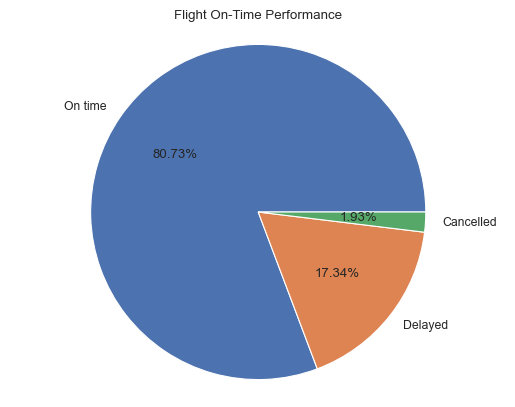

In [180]:
# create on_time column
df.loc[df['cancelled']==1, 'on_time'] = 'Cancelled'
df.loc[df['dep_del15']==0, 'on_time'] = 'On time'
df.loc[df['dep_del15']==1, 'on_time'] = 'Delayed'

# Calculate value counts for on_time column
on_time_counts = df['on_time'].value_counts()

# Create lists of labels and sizes
labels = on_time_counts.index.tolist()
sizes = on_time_counts.tolist()

# Create pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.2f%%')
ax.axis('equal')
plt.title('Flight On-Time Performance')
plt.show()

In [181]:
# cancelled flights # from our data 
len(df.loc[df['cancelled'] == 1.0])

3473

In [182]:
# remove cancelled flights
df = df.loc[df['cancelled'] == 0.0]

# remove delay of more than 480 minutes
print(len(df.loc[df['dep_delay_new']>480]))

df = df.loc[df['dep_delay_new']<=480]

190


In [183]:
# delayed flights %
print(len(df.loc[df['dep_del15'] == 1.0]) / len(df), df['dep_del15'].isnull().values.sum())

0.17561316379603864 0


In [184]:
print(df['air carrier name'].isnull().values.sum())

# Total Number of Flights by Airline
flights_airlines = df.groupby(['air carrier name'], as_index=False)['dep_del15'].count()
flights_airlines.columns = ['airline', 'total_num_flights_airline']

# Number of Delayed Flights by Airline
flights_delayed_airlines = df.groupby(['air carrier name'], as_index=False)['dep_del15'].sum()
flights_delayed_airlines.columns = ['airline', 'total_num_delayed_flights_airline']

print(flights_airlines.head())
print(flights_delayed_airlines.head())

0
                    airline  total_num_flights_airline
0           Alaska Airlines                      68938
1         American Airlines                       5158
2    Delta Air Lines, Inc.                       28857
3  Frontier Airlines, Inc.                         493
4   Hawaiian Airlines Inc.                         727
                    airline  total_num_delayed_flights_airline
0           Alaska Airlines                            13466.0
1         American Airlines                             1026.0
2    Delta Air Lines, Inc.                              4869.0
3  Frontier Airlines, Inc.                               157.0
4   Hawaiian Airlines Inc.                                97.0


In [185]:
# Percentage of Delayed Flights by Airline
percent_flights_delayed_airlines = pd.merge(flights_airlines, flights_delayed_airlines, on='airline')
percent_flights_delayed_airlines['percent_delayed_airline'] = percent_flights_delayed_airlines['total_num_delayed_flights_airline'] / percent_flights_delayed_airlines['total_num_flights_airline']
percent_flights_delayed_airlines = percent_flights_delayed_airlines.sort_values(by="total_num_flights_airline", ascending=False)
percent_flights_delayed_airlines

,airline,total_num_flights_airline,total_num_delayed_flights_airline,percent_delayed_airline
0,Alaska Airlines,68938,13466.0,0.195335
2,"Delta Air Lines, Inc.",28857,4869.0,0.168729
5,Horizon Air,28052,4287.0,0.152823
7,Skywest Airlines,20317,2265.0,0.111483
8,Southwest Airlines,8448,2042.0,0.241714
10,"United Airlines, Inc.",7590,1036.0,0.136495
1,American Airlines,5158,1026.0,0.198914
6,Jetblue Airways Corporation,920,469.0,0.509783
9,"Spirit Airlines, Inc.",846,201.0,0.237589
4,Hawaiian Airlines Inc.,727,97.0,0.133425


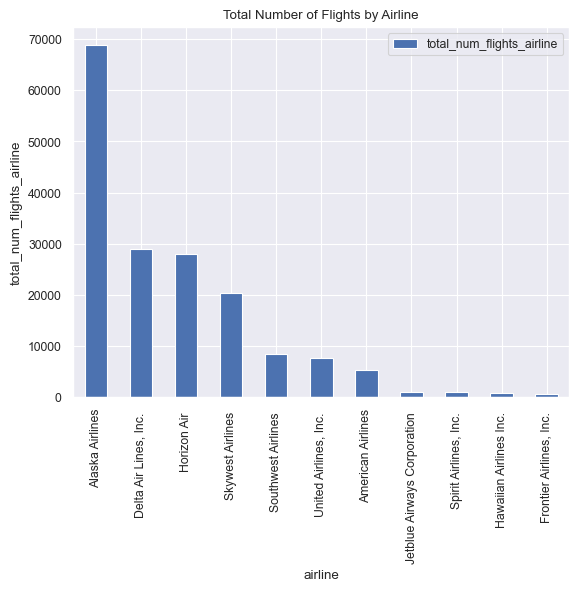

In [186]:
# Create a bar plot of the DataFrame
ax = percent_flights_delayed_airlines.plot.bar(x='airline', y='total_num_flights_airline')

# Set the plot title and axis labels
ax.set_title('Total Number of Flights by Airline')
ax.set_xlabel('airline')
ax.set_ylabel('total_num_flights_airline')

# Display the plot
plt.show()

<Figure size 1000x500 with 0 Axes>

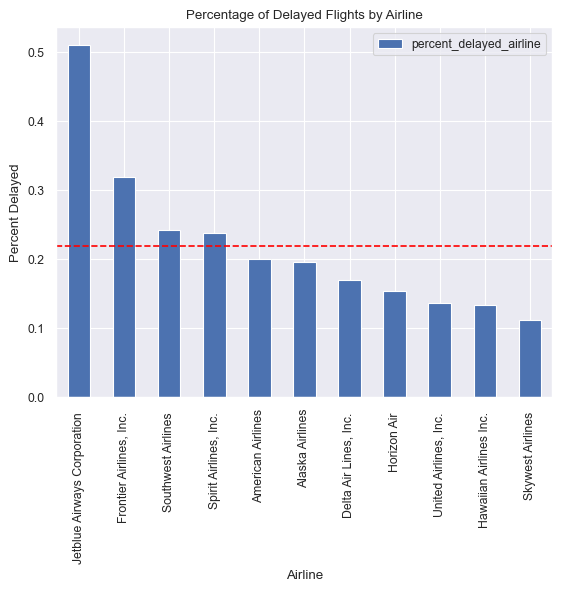

In [187]:
# Calculate the average value
avg_percent_delayed = percent_flights_delayed_airlines['percent_delayed_airline'].mean()

# Set the figure size
plt.figure(figsize=(10,5))

# Create a bar plot of the DataFrame
ax = percent_flights_delayed_airlines.sort_values(by="percent_delayed_airline", ascending=False).plot.bar(x='airline', y='percent_delayed_airline')

# Add a red line indicating the average value
ax.axhline(avg_percent_delayed, color='red', linestyle='--')

# Set the plot title and axis labels
ax.set_title('Percentage of Delayed Flights by Airline')
ax.set_xlabel('Airline')
ax.set_ylabel('Percent Delayed')

# Display the plot
plt.show()

In [188]:
# Average Delay Time by Airline
avg_delayed_time_airlines = df.groupby(['air carrier name'], as_index=False)['dep_delay_new'].mean()
avg_delayed_time_airlines.columns = ['airline', 'avg_delayed_minutes']
avg_delayed_time_airlines

,airline,avg_delayed_minutes
0,Alaska Airlines,10.495228
1,American Airlines,13.621365
2,"Delta Air Lines, Inc.",11.605434
3,"Frontier Airlines, Inc.",21.941176
4,Hawaiian Airlines Inc.,10.830812
5,Horizon Air,8.787823
6,Jetblue Airways Corporation,34.119565
7,Skywest Airlines,7.136585
8,Southwest Airlines,13.323864
9,"Spirit Airlines, Inc.",15.341608


In [189]:
# 20 Most Common Destination (Cities)
dest_top20 = df.groupby(['dest','dest_city_name'], as_index=False).size()
dest_top20.columns = ['dest','dest_city_name','num_of_flights_dest']
dest_top20.sort_values(by='num_of_flights_dest',ascending=False)[:20].reset_index(drop=True)

,dest,dest_city_name,num_of_flights_dest
0,PDX,"Portland, OR",8045
1,ANC,"Anchorage, AK",7140
2,SFO,"San Francisco, CA",6633
3,GEG,"Spokane, WA",6606
4,LAX,"Los Angeles, CA",6530
5,LAS,"Las Vegas, NV",6292
6,DEN,"Denver, CO",5988
7,PHX,"Phoenix, AZ",5980
8,BOI,"Boise, ID",5154
9,SJC,"San Jose, CA",4972


In [190]:
# Worse and Best months to travel 
month_delay = df.groupby(['month'], as_index=False)['dep_del15'].sum()
month_delay.columns = ['month', 'delayed_cnt_month']

month_flights = df.groupby(['month'], as_index=False)['dep_del15'].count()
month_flights.columns = ['month', 'flight_cnt_month']

month_flights_delay = pd.merge(month_flights, month_delay, on=['month'])
month_flights_delay['percent_delayed_month'] = month_delay['delayed_cnt_month'] / month_flights['flight_cnt_month']
month_flights_delay = month_flights_delay.sort_values(by='percent_delayed_month', ascending=False)

num = 1
for i in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
    month_flights_delay.loc[month_flights_delay['month']==num, 'month'] = i
    num += 1
month_flights_delay


,month,flight_cnt_month,delayed_cnt_month,percent_delayed_month
11,Dec,12807,4213.0,0.328961
0,Jan,12205,2741.0,0.224580
3,Apr,13495,2514.0,0.186291
5,Jun,14940,2696.0,0.180455
10,Nov,13765,2320.0,0.168543
7,Aug,16243,2730.0,0.168072
4,May,14436,2415.0,0.167290
6,Jul,16217,2553.0,0.157427
8,Sep,15721,2287.0,0.145474
2,Mar,13661,1966.0,0.143913


<Figure size 800x600 with 0 Axes>

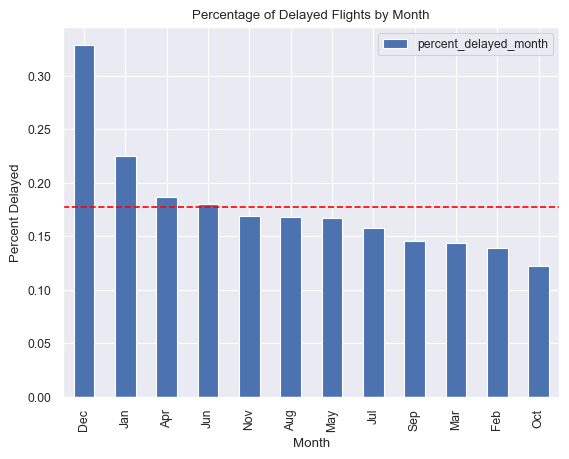

In [191]:
# Calculate the average value
avg_percent_delayed_month = month_flights_delay['percent_delayed_month'].mean()

# Set the figure size
plt.figure(figsize=(8,6))

# Create a bar plot of the DataFrame
ax = month_flights_delay.sort_values(by="percent_delayed_month", ascending=False).plot.bar(x='month', y='percent_delayed_month')

# Add a red line indicating the average value
ax.axhline(avg_percent_delayed_month, color='red', linestyle='--')

# Set the plot title and axis labels
ax.set_title('Percentage of Delayed Flights by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Percent Delayed')

# Display the plot
plt.show()


In [192]:
# Best weekday to avoid delays
day_of_week_delay = df.groupby(['day_of_week'], as_index=False)['dep_del15'].sum()
day_of_week_delay.columns = ['day_of_week', 'delayed_cnt_day_of_week']

day_of_week_flights = df.groupby(['day_of_week'], as_index=False)['dep_del15'].count()
day_of_week_flights.columns = ['day_of_week', 'flight_cnt_day_of_week']

day_of_week_flights_delay = pd.merge(day_of_week_flights, day_of_week_delay, on=['day_of_week'])
day_of_week_flights_delay['percent_delayed_day_of_week'] = day_of_week_delay['delayed_cnt_day_of_week'] / day_of_week_flights['flight_cnt_day_of_week']
day_of_week_flights_delay = day_of_week_flights_delay.sort_values(by='percent_delayed_day_of_week', ascending=False)

num = 1
for i in ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']:
    day_of_week_flights_delay.loc[day_of_week_flights_delay['day_of_week']==num, 'day_of_week'] = i
    num += 1
day_of_week_flights_delay

,day_of_week,flight_cnt_day_of_week,delayed_cnt_day_of_week,percent_delayed_day_of_week
4,Fri,25016,5055.0,0.202071
6,Sun,24682,4937.0,0.200024
0,Mon,25307,4534.0,0.179160
3,Thu,25240,4318.0,0.171078
5,Sat,22621,3808.0,0.168339
1,Tue,23640,3685.0,0.155880
2,Wed,23840,3578.0,0.150084


<Figure size 800x600 with 0 Axes>

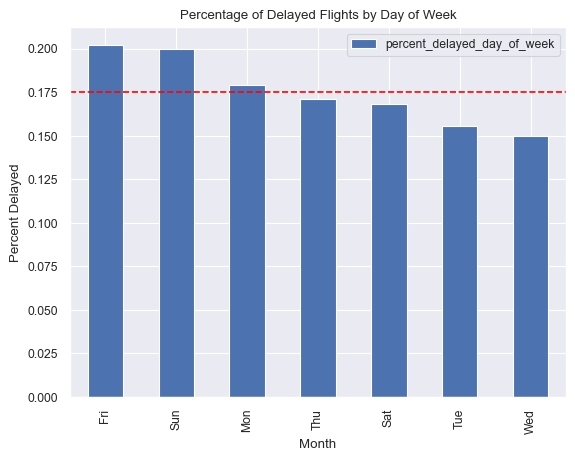

In [193]:
# Calculate the average value
avg_percent_delayed_day = day_of_week_flights_delay['percent_delayed_day_of_week'].mean()

# Set the figure size
plt.figure(figsize=(8,6))

# Create a bar plot of the DataFrame
ax = day_of_week_flights_delay.sort_values(by="percent_delayed_day_of_week", ascending=False).plot.bar(x='day_of_week', y='percent_delayed_day_of_week')

# Add a red line indicating the average value
ax.axhline(avg_percent_delayed_day, color='red', linestyle='--')

# Set the plot title and axis labels
ax.set_title('Percentage of Delayed Flights by Day of Week')
ax.set_xlabel('Month')
ax.set_ylabel('Percent Delayed')

# Display the plot
plt.show()

Modeling


Now that the data has been cleaned and gone through a thorough EDA process, its time to start with the modeling which will be a binary classification as described above.

In [194]:
# create on_time column
df.loc[(df['crs_dep_time']>=600) & (df['crs_dep_time']<900), 'day_period'] = 'early morning'
df.loc[(df['crs_dep_time']>=900) & (df['crs_dep_time']<1200), 'day_period'] = 'late morning'
df.loc[(df['crs_dep_time']>=1200) & (df['crs_dep_time']<1500), 'day_period'] = 'early afternoon'
df.loc[(df['crs_dep_time']>=1500) & (df['crs_dep_time']<1800), 'day_period'] = 'late afternoon'
df.loc[(df['crs_dep_time']>=1800) & (df['crs_dep_time']<2100), 'day_period'] = 'early evening'
df.loc[df['crs_dep_time']>=2100, 'day_period'] = 'late evening'
df.loc[df['crs_dep_time']<500, 'day_period'] = 'after midnight'

num = 1
for i in ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']:
    df.loc[df['day_of_week']==num, 'day_of_week'] = i
    num += 1

num = 1
for i in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
    df.loc[df['month']==num, 'month'] = i
    num += 1

df.head()

,month,day_of_month,day_of_week,fl_date,mkt_carrier_fl_num,op_unique_carrier,origin,origin_city_name,dest,dest_city_name,crs_dep_time,dep_time,dep_delay_new,dep_del15,cancelled,diverted,crs_elapsed_time,distance,iata code,air carrier name,date,average_wind_speed,precipitation,snowfall,snow_depth,average_temperature,maximum_temperature,minimum_temperature,fog,heavy_fog,on_time,day_period
0,Nov,1,Tue,2022-11-01,101,AS,SEA,"Seattle, WA",ANC,"Anchorage, AK",2315,2313.0,0.0,0.0,0.0,0.0,222.0,1448.0,AS,Alaska Airlines,2022-11-01,4.92,0.13,0.0,0.0,47,51,41,1,0,On time,late evening
1,Nov,1,Tue,2022-11-01,1012,AS,SEA,"Seattle, WA",MSP,"Minneapolis, MN",1825,1818.0,0.0,0.0,0.0,0.0,194.0,1399.0,AS,Alaska Airlines,2022-11-01,4.92,0.13,0.0,0.0,47,51,41,1,0,On time,early evening
2,Nov,1,Tue,2022-11-01,1014,AS,SEA,"Seattle, WA",ORD,"Chicago, IL",600,601.0,1.0,0.0,0.0,0.0,253.0,1721.0,AS,Alaska Airlines,2022-11-01,4.92,0.13,0.0,0.0,47,51,41,1,0,On time,early morning
3,Nov,1,Tue,2022-11-01,1023,DL,SEA,"Seattle, WA",CVG,"Cincinnati, OH",1005,1000.0,0.0,0.0,0.0,0.0,255.0,1965.0,DL,"Delta Air Lines, Inc.",2022-11-01,4.92,0.13,0.0,0.0,47,51,41,1,0,On time,late morning
4,Nov,1,Tue,2022-11-01,1028,DL,SEA,"Seattle, WA",LAX,"Los Angeles, CA",1348,1343.0,0.0,0.0,0.0,0.0,157.0,954.0,DL,"Delta Air Lines, Inc.",2022-11-01,4.92,0.13,0.0,0.0,47,51,41,1,0,On time,early afternoon


In [195]:
df['distance'].corr(df['dep_delay_new'])

0.04485429900314371

In [196]:
df_model = df[['month','day_of_week','op_unique_carrier','dest','dep_del15','crs_elapsed_time','day_period',
               'average_wind_speed','precipitation','snowfall','snow_depth','maximum_temperature','minimum_temperature','fog','heavy_fog']]
df_model.head()

,month,day_of_week,op_unique_carrier,dest,dep_del15,crs_elapsed_time,day_period,average_wind_speed,precipitation,snowfall,snow_depth,maximum_temperature,minimum_temperature,fog,heavy_fog
0,Nov,Tue,AS,ANC,0.0,222.0,late evening,4.92,0.13,0.0,0.0,51,41,1,0
1,Nov,Tue,AS,MSP,0.0,194.0,early evening,4.92,0.13,0.0,0.0,51,41,1,0
2,Nov,Tue,AS,ORD,0.0,253.0,early morning,4.92,0.13,0.0,0.0,51,41,1,0
3,Nov,Tue,DL,CVG,0.0,255.0,late morning,4.92,0.13,0.0,0.0,51,41,1,0
4,Nov,Tue,DL,LAX,0.0,157.0,early afternoon,4.92,0.13,0.0,0.0,51,41,1,0


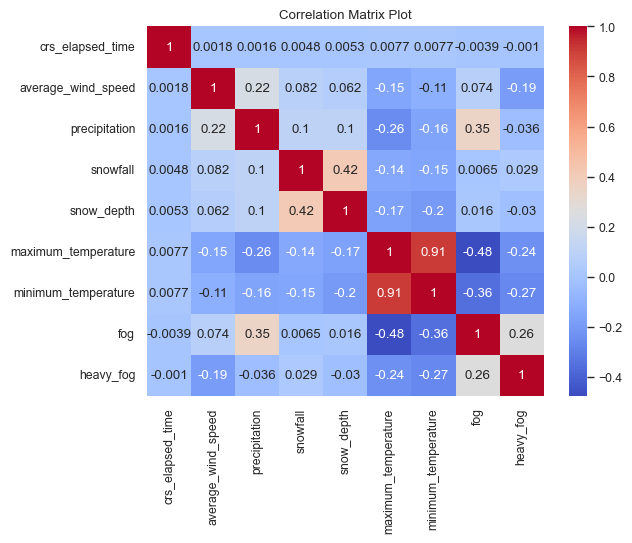

In [197]:
# Select columns to include in the correlation matrix plot
cols = ['crs_elapsed_time','average_wind_speed','precipitation','snowfall','snow_depth','maximum_temperature','minimum_temperature','fog','heavy_fog']
corr_matrix = df_model[cols].corr()

# Create a heatmap plot of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Plot')
plt.show()

In [198]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170346 entries, 0 to 174008
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                170346 non-null  object 
 1   day_of_week          170346 non-null  object 
 2   op_unique_carrier    170346 non-null  object 
 3   dest                 170346 non-null  object 
 4   dep_del15            170346 non-null  float64
 5   crs_elapsed_time     170346 non-null  float64
 6   day_period           167766 non-null  object 
 7   average_wind_speed   170346 non-null  float64
 8   precipitation        170346 non-null  float64
 9   snowfall             170346 non-null  float64
 10  snow_depth           170346 non-null  float64
 11  maximum_temperature  170346 non-null  int64  
 12  minimum_temperature  170346 non-null  int64  
 13  fog                  170346 non-null  int64  
 14  heavy_fog            170346 non-null  int64  
dtypes: float64(6), in

In [199]:
df_model

,month,day_of_week,op_unique_carrier,dest,dep_del15,crs_elapsed_time,day_period,average_wind_speed,precipitation,snowfall,snow_depth,maximum_temperature,minimum_temperature,fog,heavy_fog
0,Nov,Tue,AS,ANC,0.0,222.0,late evening,4.92,0.13,0.0,0.0,51,41,1,0
1,Nov,Tue,AS,MSP,0.0,194.0,early evening,4.92,0.13,0.0,0.0,51,41,1,0
2,Nov,Tue,AS,ORD,0.0,253.0,early morning,4.92,0.13,0.0,0.0,51,41,1,0
3,Nov,Tue,DL,CVG,0.0,255.0,late morning,4.92,0.13,0.0,0.0,51,41,1,0
4,Nov,Tue,DL,LAX,0.0,157.0,early afternoon,4.92,0.13,0.0,0.0,51,41,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174004,Jan,Mon,WN,PHX,0.0,160.0,late afternoon,9.17,0.00,0.0,0.0,46,35,0,0
174005,Jan,Mon,DL,ATL,0.0,285.0,early morning,9.17,0.00,0.0,0.0,46,35,0,0
174006,Jan,Mon,DL,TPA,0.0,324.0,early morning,9.17,0.00,0.0,0.0,46,35,0,0
174007,Jan,Mon,DL,SLC,0.0,121.0,late morning,9.17,0.00,0.0,0.0,46,35,0,0


In [200]:
print(len(np.unique(df['dest'])))
# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Apply the encoder to the 'dest' column
df_model['dest_encoded'] = encoder.fit_transform(df_model['dest'])

93


/var/folders/2_/s_zjqk_1525359z27gq08hpr0000gn/T/ipykernel_18940/1227133656.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['dest_encoded'] = encoder.fit_transform(df_model['dest'])


In [201]:
# Specify columns to encode
print(len(np.unique(df['op_unique_carrier'])))
columns_to_encode = ['month','day_of_week','op_unique_carrier','day_period']

# One-hot encode columns
one_hot_encoded = pd.get_dummies(df_model[columns_to_encode])

# Drop original columns to be encoded
df_model_dropped = df_model.drop(columns_to_encode+['dest'], axis=1)

# Concatenate the one-hot encoded columns with the original DataFrame
df_model = pd.concat([df_model_dropped, one_hot_encoded], axis=1)

11


In [202]:
# Select the last 111 column names
last_column_names = df_model.columns[-37:]
# Replace True with 1 and False with 0 in columns
for col in last_column_names:
    df_model[col] = df_model[col].replace({True: 1, False: 0})
    
df_model.head()


,dep_del15,crs_elapsed_time,average_wind_speed,precipitation,snowfall,snow_depth,maximum_temperature,minimum_temperature,fog,heavy_fog,dest_encoded,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,day_of_week_Fri,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,day_of_week_Wed,op_unique_carrier_AA,op_unique_carrier_AS,op_unique_carrier_B6,op_unique_carrier_DL,op_unique_carrier_F9,op_unique_carrier_HA,op_unique_carrier_NK,op_unique_carrier_OO,op_unique_carrier_QX,op_unique_carrier_UA,op_unique_carrier_WN,day_period_after midnight,day_period_early afternoon,day_period_early evening,day_period_early morning,day_period_late afternoon,day_period_late evening,day_period_late morning
0,0.0,222.0,4.92,0.13,0.0,0.0,51,41,1,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,194.0,4.92,0.13,0.0,0.0,51,41,1,0,57,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0.0,253.0,4.92,0.13,0.0,0.0,51,41,1,0,64,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.0,255.0,4.92,0.13,0.0,0.0,51,41,1,0,17,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.0,157.0,4.92,0.13,0.0,0.0,51,41,1,0,47,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [203]:
# Separate independent and dependent variables 
X = df_model.drop('dep_del15', axis=1)
X.shape

(170346, 47)

In [204]:
# Define target (dependtable variable)
y = df_model['dep_del15']
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: dep_del15, dtype: float64

split into train and test sets

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (136276, 47) (136276,)
Test set: (34070, 47) (34070,)


In [206]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [207]:
def train(model, X_train, y_train, X_test, y_test, params, output=False, return_model=False):

    # Naive Bayes
    if model == 'gnb':
        model_fit = GaussianNB(**params)
    # Logistic Regression
    if model == 'logistic':
        model_fit = LogisticRegression(**params)
        
    model_fit.fit(X_train,y_train)
    y_pred = model_fit.predict(X_test)

    if output==True:
        confusionMatrix = confusion_matrix(y_test, y_pred)
        score = model_fit.score(X_test,y_test)
        print("Test Score:", score)

        print("F1 score :",f1_score(y_test, y_pred))
        print("Precision Score :" , precision_score(y_test, y_pred))
        print("Recall Score :" , recall_score(y_test, y_pred)) 
        print(classification_report(y_test, y_pred))

        sns.set(context="paper")
        plt.subplots(figsize=(6,6))
        sns.heatmap(confusionMatrix, annot=True, fmt=".0f", linewidths=1.5, square=True)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.title("Confusion Matrix", size = 15)
        plt.show()

    if return_model==True:
        return model_fit


In [208]:
def plot_feature_importance(importance,names,model_type,top_n=None):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(8,6))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'][:top_n])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')


In [209]:
def plotRocAuc(model, X_test, y_test, labels):

    y_pred = model.predict_proba(X_test)

    fpr, tpr, threshold= metrics.roc_curve(y_test, y_pred[:, 1])
    roc_auc = metrics.auc(fpr, tpr)

    plt.subplots(figsize=(6,6))
    plt.title("Receiver Operating Characteristic", fontsize=14)
    plt.plot(fpr, tpr, label = labels + " AUC = %0.2f"%roc_auc)
    plt.plot([0,1], [0,1], "--", label="Random guessing")
    plt.legend(loc = "lower right", prop={'size': 12})
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")

    plt.show()   

Naive Bayes

Test Score: 0.7931904901673026
F1 score : 0.2654295246038365
Precision Score : 0.35272928789138264
Recall Score : 0.2127695136219288
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88     28087
         1.0       0.35      0.21      0.27      5983

    accuracy                           0.79     34070
   macro avg       0.60      0.56      0.57     34070
weighted avg       0.76      0.79      0.77     34070



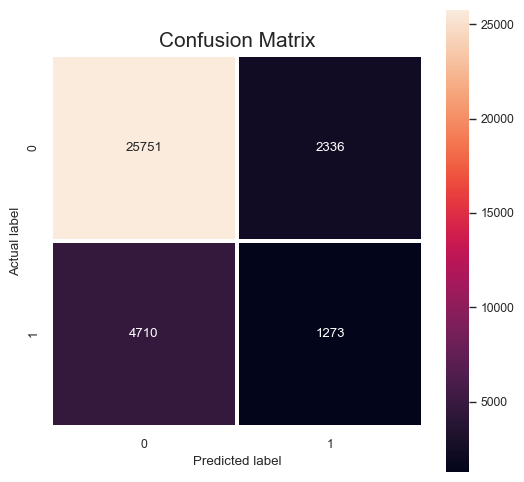

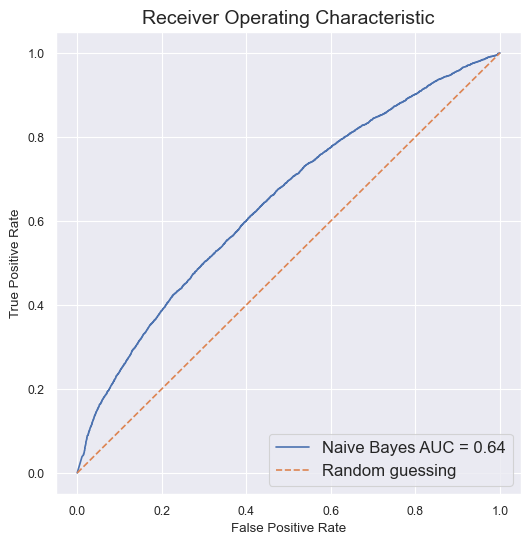

In [210]:
param_grid = {}
train("gnb", X_train, y_train, X_test, y_test, params=param_grid, output=True, return_model=False)
model_fit = train("gnb", X_train, y_train, X_test, y_test, params=param_grid, output=False, return_model=True)
plotRocAuc(model=model_fit, X_test=X_test, y_test=y_test, labels='Naive Bayes')

Logistic regression

Test Score: 0.8253008511887291
F1 score : 0.07260828918666251
Precision Score : 0.535632183908046
Recall Score : 0.038943673742269765
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90     28087
         1.0       0.54      0.04      0.07      5983

    accuracy                           0.83     34070
   macro avg       0.68      0.52      0.49     34070
weighted avg       0.78      0.83      0.76     34070



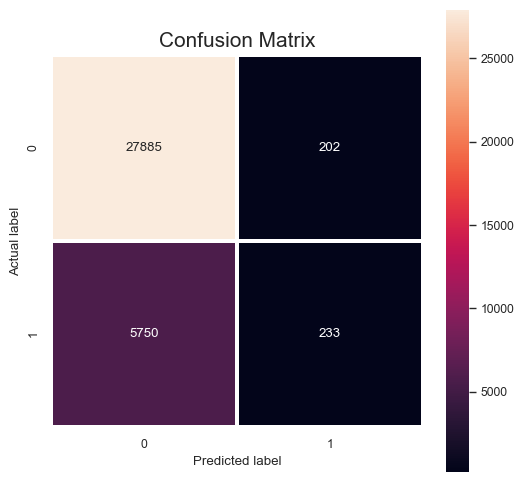

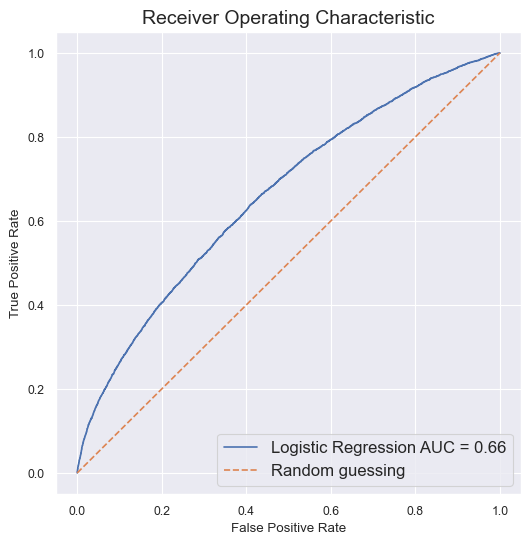

In [211]:
param_grid = {}
train("logistic", X_train, y_train, X_test, y_test, params=param_grid, output=True, return_model=False)
model_fit = train("logistic", X_train, y_train, X_test, y_test, params=param_grid, output=False, return_model=True)
plotRocAuc(model=model_fit, X_test=X_test, y_test=y_test, labels='Logistic Regression')

0
1


<Figure size 640x480 with 0 Axes>

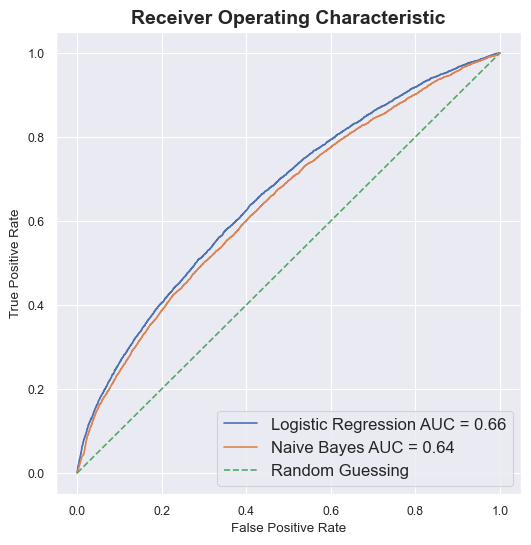

In [212]:
models = ['logistic','gnb']
params = [{}, 
          {}]
labels = ['Logistic Regression','Naive Bayes']
plt.clf()
plt.subplots(figsize=(6,6))

for i in range(len(models)):
    print(i)
    trainedModel = train(models[i], X_train, y_train, X_test, y_test, params[i],  output=False, return_model=True)
    
    y_pred = trainedModel.predict_proba(X_test)
    fpr, tpr, threshold= metrics.roc_curve(y_test, y_pred[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = labels[i] + " AUC = %0.2f"%roc_auc)

plt.plot([0,1], [0,1], "--", label="Random Guessing")
    
plt.title("Receiver Operating Characteristic", fontsize=14, fontweight = "bold")
plt.legend(loc = "lower right", prop={'size': 12})
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

plt.show()          